In [32]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from PIL import Image
import torch
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121, densenet201
from monai.transforms import (
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor
)
from monai.utils import set_determinism

#from data_split import data_separator, get_oversampling
#from data_loader import load_and_preprocess_image, generate_path_dataset, augmenter
#from model_creation import start_model, set_check_poin_saver, set_check_point_saver_regression
#from model_evaluation import plot_model_history, get_dataset_prediction, evaluate_prediction

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
df = pd.read_csv("/home/12559743/DAVI/IC/Codes/data_aug.csv")
print(len(df))

1455


In [4]:
print(df.iloc[1430]['Patient'], df.iloc[1430]['PAN Date'], df.iloc[1430]['PAN Path'])

nan nan /home/12559743/DAVI/todos_pacientes/ZILDA SCHIAVON CAMILLO/ZILDA SCHIAVON CAMILLO- -- - - - 15-09-1961- PX from 29-02-2016 S0 I0aug_cr.jpg


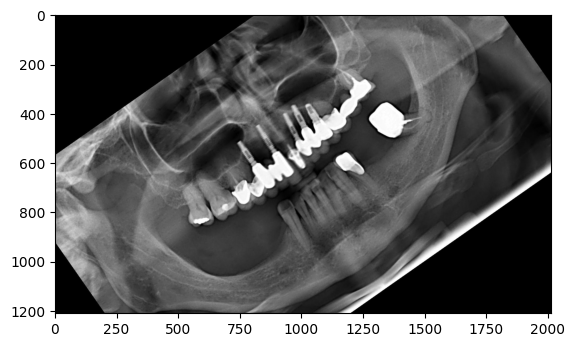

In [5]:
img = plt.imread(df.iloc[1450]['PAN Path'])
plt.imshow(img)

In [6]:
from sklearn.model_selection import train_test_split as splitter
import random

def data_separator(data, train_rate=0.70, val_rate=0.50, SEED=42):
    
    '''
        Applies train, val, test split.
    '''
    
    # Separando train, val and test IMAGE path list
    
    if not val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        return train, test
        
    elif val_rate:
        train, test = splitter(data, test_size= 1-train_rate, shuffle=True, random_state=SEED)
        
        val, test = splitter(test, test_size= 1-val_rate, shuffle=True, random_state=SEED)

        return train, val, test 



In [7]:
train, val, test = data_separator(df, train_rate=.8, val_rate=.5)
    
print(len(train), len(val), len(test))

1164 145 146


In [8]:
train_list = (list(train['PAN Path']), list(train['Sex']))
val_list = (list(val['PAN Path']), list(val['Sex']))
test_list = (list(test['PAN Path']), list(test['Sex']))

print(len(train), len(val), len(test))

1164 145 146


In [10]:
image_list_train =[]
image_list_train_y = []

for i in range(len(train)):
    #print(i)
    x = cv2.imread(train_list[0][i])
    x = cv2.resize(x, (224, 224))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_train.append(x)
    image_list_train_y.append(train_list[1][i])
    
image_list_val = []
image_list_val_y = []

for i in range(len(val)):
    #print(i)
    x = cv2.imread(val_list[0][i])
    x = cv2.resize(x, (224, 224))
    X = cv2.cvtColor(x,  cv2.COLOR_BGR2RGB)
    image_list_val.append(x)
    image_list_val_y.append(val_list[1][i])
    
    
    
image_list_test = []
image_list_test_y = []

for i in range(len(test)):
    #print(i)
    x = cv2.imread(test_list[0][i])
    x = cv2.resize(x, (224, 224))
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    image_list_test.append(x)
    image_list_test_y.append(test_list[1][i])

In [11]:
image_list_train_y = np.array(image_list_train_y)
image_list_val_y = np.array(image_list_val_y)
image_list_test_y = np.array(image_list_test_y)

In [12]:
image_list_test_y[7]

0

In [13]:
w, h , c= image_list_train[0].shape

In [14]:
image_list_train = np.array(image_list_train)
image_list_val = np.array(image_list_val)
image_list_test = np.array(image_list_test)

In [15]:
image_list_train = image_list_train.reshape((-1, w,h,3))
image_list_val = image_list_val.reshape((-1, w,h,3))
image_list_test = image_list_test.reshape((-1, w,h,3))

In [16]:
from torchvision import transforms

normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224,0.225 ])
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

image_list_train_tensor = torch.stack([transform(image) for image in image_list_train])
image_list_val_tensor = torch.stack([transform(image) for image in image_list_val])
image_list_test_tensor = torch.stack([transform(image) for image in image_list_test])

In [17]:
image_list_train_tensor.shape

torch.Size([1164, 3, 224, 224])

In [18]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels = None, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx] if self.labels is not None else None
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
def transform_image(image):
    image = torch.tensor(image, dtype=torch.float32)
    
    image = image / 255.0
    return image

dataset = CustomDataset(image_list_train, image_list_train_y, transform = transform_image)

In [19]:
batch_size = 16

train_ds = CustomDataset(image_list_train_tensor, image_list_train_y, transform_image)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

val_ds = CustomDataset(image_list_val_tensor, image_list_val_y, transform_image)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=4)

test_ds = CustomDataset(image_list_test_tensor, image_list_test_y, transform_image)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [27]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_v2_s
import timm


class MyModel(nn.Module):
    def __init__(self, drop_prob = 0.2):
        super(MyModel, self).__init__()
        
        self.efficientnet = efficientnet_v2_s(weights='DEFAULT')
        
        for param in self.efficientnet.parameters():
            param.requires_grad = True
        
        
        num_ftrs = self.efficientnet.classifier[-1].in_features
        
        self.efficientnet.classifier[-1] = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, 64)
        self.dropout1 = nn.Dropout(drop_prob)
        self.fc2 = nn.Linear(64, 16)
        self.dropout2 = nn.Dropout(drop_prob)
        self.fc3 = nn.Linear(16,1)
        
    def forward(self, x):
        x = self.efficientnet(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        
        threshold = 0.5
        x = (x>threshold).float()
        return x
    
    
    
drop_prob = 0.2
model = MyModel(drop_prob)

In [21]:
class Complexity:
    def __init__(self):
        self.bins = 100

    def entropy(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        prob = histogram
        log_prob = histogram.log()
        plogp = prob*log_prob
        plogp[torch.isnan(plogp)] = 0
        return plogp.sum().detach().cpu().numpy()

    def desiquilibrium(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        histogram = histogram - self.normal_prob()
        return histogram.square().sum().cpu().numpy()

    def complexity(self, p):
        return self.entropy(p) * self.desiquilibrium(p)


    def normal_prob(self):
        return 1.0/self.bins

def extract_model_data(model, model_data=None):
    if model_data is None:
        model_data = dict()
    c = Complexity()
    for name, param in model.named_parameters():
        if param.requires_grad:
            # we got a valid parameter to extract
            if name not in model_data.keys():
                model_data[name] = {'entropy' : list(), 'desiquilibrium' : list(), 'complexity' : list() }
            model_data[name]['entropy'].append(c.entropy(param.data))
            model_data[name]['desiquilibrium'].append(c.desiquilibrium(param.data))
            model_data[name]['complexity'].append(c.complexity(param.data))
    return model_data

In [22]:
loss_function = torch.nn.BCELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), 1e-4)


In [39]:
import tempfile
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpd6189h_h


In [40]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

max_epochs = 50
val_interval = 1


model.to(device)


model_data = None
single_complexity = list()
single_loss = list()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze(dim=1)
        loss = loss_function(outputs, labels)
        #loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

        # EXTRACT MODEL DATA
        model_data = extract_model_data(model, model_data)
        myp = torch.nn.utils.parameters_to_vector(model.parameters())
        single_complexity.append(Complexity().complexity(myp))
        single_loss.append(loss.item())

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            auc_metric = compute_roc_auc(
                y_pred, y)
            metric_values.append(auc_metric)
            '''
            y_one_hot = label_binarize(y.cpu().numpy(), classes=np.arange(num_classes))
            fpr, tpr, _ = roc_curve(y_one_hot.ravel(), y_pred.cpu().numpy().ravel())
            auc_value = auc(fpr, tpr)
            '''
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 50.0000
3/72, train_loss: 37.5000
4/72, train_loss: 37.5000
5/72, train_loss: 56.2500
6/72, train_loss: 50.0000
7/72, train_loss: 37.5000
8/72, train_loss: 37.5000
9/72, train_loss: 31.2500
10/72, train_loss: 43.7500
11/72, train_loss: 25.0000
12/72, train_loss: 43.7500
13/72, train_loss: 56.2500
14/72, train_loss: 56.2500
15/72, train_loss: 37.5000
16/72, train_loss: 62.5000
17/72, train_loss: 31.2500
18/72, train_loss: 31.2500
19/72, train_loss: 31.2500
20/72, train_loss: 62.5000
21/72, train_loss: 68.7500
22/72, train_loss: 37.5000
23/72, train_loss: 50.0000
24/72, train_loss: 31.2500
25/72, train_loss: 56.2500
26/72, train_loss: 43.7500
27/72, train_loss: 18.7500
28/72, train_loss: 56.2500
29/72, train_loss: 37.5000
30/72, train_loss: 50.0000
31/72, train_loss: 50.0000
32/72, train_loss: 50.0000
33/72, train_loss: 25.0000
34/72, train_loss: 62.5000
35/72, train_loss: 25.0000
36/72, train_loss: 37.5000
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saved new best metric model
current epoch: 1 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 2/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 56.2500
2/72, train_loss: 31.2500
3/72, train_loss: 37.5000
4/72, train_loss: 50.0000
5/72, train_loss: 43.7500
6/72, train_loss: 31.2500
7/72, train_loss: 56.2500
8/72, train_loss: 56.2500
9/72, train_loss: 50.0000
10/72, train_loss: 37.5000
11/72, train_loss: 50.0000
12/72, train_loss: 43.7500
13/72, train_loss: 56.2500
14/72, train_loss: 31.2500
15/72, train_loss: 43.7500
16/72, train_loss: 31.2500
17/72, train_loss: 43.7500
18/72, train_loss: 50.0000
19/72, train_loss: 37.5000
20/72, train_loss: 75.0000
21/72, train_loss: 56.2500
22/72, train_loss: 56.2500
23/72, train_loss: 56.2500
24/72, train_loss: 37.5000
25/72, train_loss: 43.7500
26/72, train_loss: 68.7500
27/72, train_loss: 37.5000
28/72, train_loss: 31.2500
29/72, train_loss: 43.7500
30/72, train_loss: 31.2500
31/72, train_loss: 50.0000
32/72, train_loss: 43.7500
33/72, train_loss: 31.2500
34/72, train_loss: 62.5000
35/72, train_loss: 56.2500
36/72, train_loss: 62.5000
37/72, train_loss: 43.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 2 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 3/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 43.7500
2/72, train_loss: 56.2500
3/72, train_loss: 43.7500
4/72, train_loss: 31.2500
5/72, train_loss: 43.7500
6/72, train_loss: 43.7500
7/72, train_loss: 37.5000
8/72, train_loss: 37.5000
9/72, train_loss: 31.2500
10/72, train_loss: 56.2500
11/72, train_loss: 56.2500
12/72, train_loss: 68.7500
13/72, train_loss: 31.2500
14/72, train_loss: 31.2500
15/72, train_loss: 37.5000
16/72, train_loss: 31.2500
17/72, train_loss: 43.7500
18/72, train_loss: 43.7500
19/72, train_loss: 43.7500
20/72, train_loss: 37.5000
21/72, train_loss: 31.2500
22/72, train_loss: 31.2500
23/72, train_loss: 18.7500
24/72, train_loss: 50.0000
25/72, train_loss: 62.5000
26/72, train_loss: 37.5000
27/72, train_loss: 37.5000
28/72, train_loss: 50.0000
29/72, train_loss: 56.2500
30/72, train_loss: 68.7500
31/72, train_loss: 37.5000
32/72, train_loss: 50.0000
33/72, train_loss: 56.2500
34/72, train_loss: 37.5000
35/72, train_loss: 50.0000
36/72, train_loss: 43.7500
37/72, train_loss: 62.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 3 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 4/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 56.2500
3/72, train_loss: 56.2500
4/72, train_loss: 50.0000
5/72, train_loss: 31.2500
6/72, train_loss: 18.7500
7/72, train_loss: 31.2500
8/72, train_loss: 56.2500
9/72, train_loss: 68.7500
10/72, train_loss: 43.7500
11/72, train_loss: 50.0000
12/72, train_loss: 25.0000
13/72, train_loss: 50.0000
14/72, train_loss: 56.2500
15/72, train_loss: 31.2500
16/72, train_loss: 62.5000
17/72, train_loss: 50.0000
18/72, train_loss: 37.5000
19/72, train_loss: 68.7500
20/72, train_loss: 50.0000
21/72, train_loss: 31.2500
22/72, train_loss: 43.7500
23/72, train_loss: 31.2500
24/72, train_loss: 43.7500
25/72, train_loss: 37.5000
26/72, train_loss: 31.2500
27/72, train_loss: 56.2500
28/72, train_loss: 25.0000
29/72, train_loss: 37.5000
30/72, train_loss: 56.2500
31/72, train_loss: 68.7500
32/72, train_loss: 56.2500
33/72, train_loss: 50.0000
34/72, train_loss: 18.7500
35/72, train_loss: 31.2500
36/72, train_loss: 62.5000
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 4 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 5/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 25.0000
2/72, train_loss: 56.2500
3/72, train_loss: 37.5000
4/72, train_loss: 50.0000
5/72, train_loss: 43.7500
6/72, train_loss: 43.7500
7/72, train_loss: 37.5000
8/72, train_loss: 62.5000
9/72, train_loss: 56.2500
10/72, train_loss: 25.0000
11/72, train_loss: 37.5000
12/72, train_loss: 50.0000
13/72, train_loss: 43.7500
14/72, train_loss: 31.2500
15/72, train_loss: 43.7500
16/72, train_loss: 37.5000
17/72, train_loss: 31.2500
18/72, train_loss: 25.0000
19/72, train_loss: 62.5000
20/72, train_loss: 50.0000
21/72, train_loss: 31.2500
22/72, train_loss: 50.0000
23/72, train_loss: 31.2500
24/72, train_loss: 43.7500
25/72, train_loss: 50.0000
26/72, train_loss: 31.2500
27/72, train_loss: 37.5000
28/72, train_loss: 50.0000
29/72, train_loss: 31.2500
30/72, train_loss: 43.7500
31/72, train_loss: 31.2500
32/72, train_loss: 43.7500
33/72, train_loss: 68.7500
34/72, train_loss: 62.5000
35/72, train_loss: 56.2500
36/72, train_loss: 62.5000
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 5 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 6/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 37.5000
3/72, train_loss: 37.5000
4/72, train_loss: 62.5000
5/72, train_loss: 62.5000
6/72, train_loss: 43.7500
7/72, train_loss: 43.7500
8/72, train_loss: 37.5000
9/72, train_loss: 37.5000
10/72, train_loss: 50.0000
11/72, train_loss: 25.0000
12/72, train_loss: 50.0000
13/72, train_loss: 56.2500
14/72, train_loss: 50.0000
15/72, train_loss: 25.0000
16/72, train_loss: 43.7500
17/72, train_loss: 43.7500
18/72, train_loss: 50.0000
19/72, train_loss: 25.0000
20/72, train_loss: 50.0000
21/72, train_loss: 43.7500
22/72, train_loss: 50.0000
23/72, train_loss: 43.7500
24/72, train_loss: 37.5000
25/72, train_loss: 50.0000
26/72, train_loss: 62.5000
27/72, train_loss: 31.2500
28/72, train_loss: 56.2500
29/72, train_loss: 31.2500
30/72, train_loss: 43.7500
31/72, train_loss: 56.2500
32/72, train_loss: 43.7500
33/72, train_loss: 50.0000
34/72, train_loss: 43.7500
35/72, train_loss: 56.2500
36/72, train_loss: 56.2500
37/72, train_loss: 43.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 6 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 7/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 62.5000
2/72, train_loss: 31.2500
3/72, train_loss: 56.2500
4/72, train_loss: 50.0000
5/72, train_loss: 43.7500
6/72, train_loss: 31.2500
7/72, train_loss: 37.5000
8/72, train_loss: 43.7500
9/72, train_loss: 56.2500
10/72, train_loss: 37.5000
11/72, train_loss: 43.7500
12/72, train_loss: 31.2500
13/72, train_loss: 37.5000
14/72, train_loss: 56.2500
15/72, train_loss: 50.0000
16/72, train_loss: 18.7500
17/72, train_loss: 37.5000
18/72, train_loss: 37.5000
19/72, train_loss: 43.7500
20/72, train_loss: 68.7500
21/72, train_loss: 62.5000
22/72, train_loss: 43.7500
23/72, train_loss: 50.0000
24/72, train_loss: 50.0000
25/72, train_loss: 56.2500
26/72, train_loss: 37.5000
27/72, train_loss: 50.0000
28/72, train_loss: 81.2500
29/72, train_loss: 31.2500
30/72, train_loss: 62.5000
31/72, train_loss: 43.7500
32/72, train_loss: 50.0000
33/72, train_loss: 43.7500
34/72, train_loss: 50.0000
35/72, train_loss: 43.7500
36/72, train_loss: 31.2500
37/72, train_loss: 43.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 7 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 8/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 62.5000
3/72, train_loss: 43.7500
4/72, train_loss: 43.7500
5/72, train_loss: 62.5000
6/72, train_loss: 31.2500
7/72, train_loss: 43.7500
8/72, train_loss: 56.2500
9/72, train_loss: 62.5000
10/72, train_loss: 43.7500
11/72, train_loss: 31.2500
12/72, train_loss: 31.2500
13/72, train_loss: 62.5000
14/72, train_loss: 56.2500
15/72, train_loss: 31.2500
16/72, train_loss: 31.2500
17/72, train_loss: 50.0000
18/72, train_loss: 31.2500
19/72, train_loss: 50.0000
20/72, train_loss: 43.7500
21/72, train_loss: 62.5000
22/72, train_loss: 18.7500
23/72, train_loss: 43.7500
24/72, train_loss: 25.0000
25/72, train_loss: 56.2500
26/72, train_loss: 37.5000
27/72, train_loss: 25.0000
28/72, train_loss: 25.0000
29/72, train_loss: 43.7500
30/72, train_loss: 43.7500
31/72, train_loss: 31.2500
32/72, train_loss: 62.5000
33/72, train_loss: 43.7500
34/72, train_loss: 31.2500
35/72, train_loss: 37.5000
36/72, train_loss: 56.2500
37/72, train_loss: 62.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 8 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 9/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 43.7500
3/72, train_loss: 50.0000
4/72, train_loss: 68.7500
5/72, train_loss: 37.5000
6/72, train_loss: 43.7500
7/72, train_loss: 37.5000
8/72, train_loss: 50.0000
9/72, train_loss: 31.2500
10/72, train_loss: 37.5000
11/72, train_loss: 50.0000
12/72, train_loss: 43.7500
13/72, train_loss: 43.7500
14/72, train_loss: 37.5000
15/72, train_loss: 25.0000
16/72, train_loss: 43.7500
17/72, train_loss: 50.0000
18/72, train_loss: 37.5000
19/72, train_loss: 56.2500
20/72, train_loss: 50.0000
21/72, train_loss: 56.2500
22/72, train_loss: 50.0000
23/72, train_loss: 50.0000
24/72, train_loss: 50.0000
25/72, train_loss: 37.5000
26/72, train_loss: 37.5000
27/72, train_loss: 25.0000
28/72, train_loss: 25.0000
29/72, train_loss: 43.7500
30/72, train_loss: 37.5000
31/72, train_loss: 37.5000
32/72, train_loss: 31.2500
33/72, train_loss: 37.5000
34/72, train_loss: 50.0000
35/72, train_loss: 56.2500
36/72, train_loss: 62.5000
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 9 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 10/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 43.7500
3/72, train_loss: 37.5000
4/72, train_loss: 31.2500
5/72, train_loss: 43.7500
6/72, train_loss: 31.2500
7/72, train_loss: 56.2500
8/72, train_loss: 18.7500
9/72, train_loss: 25.0000
10/72, train_loss: 31.2500
11/72, train_loss: 37.5000
12/72, train_loss: 37.5000
13/72, train_loss: 50.0000
14/72, train_loss: 56.2500
15/72, train_loss: 56.2500
16/72, train_loss: 43.7500
17/72, train_loss: 43.7500
18/72, train_loss: 50.0000
19/72, train_loss: 31.2500
20/72, train_loss: 37.5000
21/72, train_loss: 43.7500
22/72, train_loss: 50.0000
23/72, train_loss: 56.2500
24/72, train_loss: 37.5000
25/72, train_loss: 62.5000
26/72, train_loss: 37.5000
27/72, train_loss: 56.2500
28/72, train_loss: 50.0000
29/72, train_loss: 43.7500
30/72, train_loss: 62.5000
31/72, train_loss: 62.5000
32/72, train_loss: 50.0000
33/72, train_loss: 50.0000
34/72, train_loss: 37.5000
35/72, train_loss: 25.0000
36/72, train_loss: 43.7500
37/72, train_loss: 12.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 10 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 11/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 31.2500
2/72, train_loss: 37.5000
3/72, train_loss: 56.2500
4/72, train_loss: 56.2500
5/72, train_loss: 62.5000
6/72, train_loss: 62.5000
7/72, train_loss: 43.7500
8/72, train_loss: 56.2500
9/72, train_loss: 37.5000
10/72, train_loss: 50.0000
11/72, train_loss: 43.7500
12/72, train_loss: 31.2500
13/72, train_loss: 50.0000
14/72, train_loss: 37.5000
15/72, train_loss: 43.7500
16/72, train_loss: 50.0000
17/72, train_loss: 31.2500
18/72, train_loss: 31.2500
19/72, train_loss: 37.5000
20/72, train_loss: 25.0000
21/72, train_loss: 43.7500
22/72, train_loss: 31.2500
23/72, train_loss: 31.2500
24/72, train_loss: 56.2500
25/72, train_loss: 43.7500
26/72, train_loss: 37.5000
27/72, train_loss: 31.2500
28/72, train_loss: 50.0000
29/72, train_loss: 37.5000
30/72, train_loss: 50.0000
31/72, train_loss: 56.2500
32/72, train_loss: 18.7500
33/72, train_loss: 43.7500
34/72, train_loss: 31.2500
35/72, train_loss: 43.7500
36/72, train_loss: 68.7500
37/72, train_loss: 62.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 11 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 12/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 31.2500
2/72, train_loss: 50.0000
3/72, train_loss: 62.5000
4/72, train_loss: 31.2500
5/72, train_loss: 56.2500
6/72, train_loss: 62.5000
7/72, train_loss: 25.0000
8/72, train_loss: 43.7500
9/72, train_loss: 37.5000
10/72, train_loss: 37.5000
11/72, train_loss: 43.7500
12/72, train_loss: 50.0000
13/72, train_loss: 56.2500
14/72, train_loss: 25.0000
15/72, train_loss: 56.2500
16/72, train_loss: 37.5000
17/72, train_loss: 43.7500
18/72, train_loss: 56.2500
19/72, train_loss: 12.5000
20/72, train_loss: 43.7500
21/72, train_loss: 25.0000
22/72, train_loss: 37.5000
23/72, train_loss: 56.2500
24/72, train_loss: 56.2500
25/72, train_loss: 43.7500
26/72, train_loss: 68.7500
27/72, train_loss: 50.0000
28/72, train_loss: 56.2500
29/72, train_loss: 50.0000
30/72, train_loss: 31.2500
31/72, train_loss: 62.5000
32/72, train_loss: 37.5000
33/72, train_loss: 50.0000
34/72, train_loss: 43.7500
35/72, train_loss: 43.7500
36/72, train_loss: 56.2500
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 12 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 13/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 43.7500
2/72, train_loss: 43.7500
3/72, train_loss: 43.7500
4/72, train_loss: 50.0000
5/72, train_loss: 37.5000
6/72, train_loss: 56.2500
7/72, train_loss: 18.7500
8/72, train_loss: 37.5000
9/72, train_loss: 56.2500
10/72, train_loss: 56.2500
11/72, train_loss: 37.5000
12/72, train_loss: 25.0000
13/72, train_loss: 18.7500
14/72, train_loss: 43.7500
15/72, train_loss: 50.0000
16/72, train_loss: 25.0000
17/72, train_loss: 56.2500
18/72, train_loss: 37.5000
19/72, train_loss: 50.0000
20/72, train_loss: 56.2500
21/72, train_loss: 43.7500
22/72, train_loss: 43.7500
23/72, train_loss: 31.2500
24/72, train_loss: 50.0000
25/72, train_loss: 31.2500
26/72, train_loss: 12.5000
27/72, train_loss: 43.7500
28/72, train_loss: 50.0000
29/72, train_loss: 37.5000
30/72, train_loss: 62.5000
31/72, train_loss: 62.5000
32/72, train_loss: 43.7500
33/72, train_loss: 43.7500
34/72, train_loss: 37.5000
35/72, train_loss: 31.2500
36/72, train_loss: 62.5000
37/72, train_loss: 25.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 13 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 14/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 25.0000
2/72, train_loss: 50.0000
3/72, train_loss: 37.5000
4/72, train_loss: 56.2500
5/72, train_loss: 50.0000
6/72, train_loss: 50.0000
7/72, train_loss: 25.0000
8/72, train_loss: 25.0000
9/72, train_loss: 37.5000
10/72, train_loss: 62.5000
11/72, train_loss: 56.2500
12/72, train_loss: 43.7500
13/72, train_loss: 50.0000
14/72, train_loss: 68.7500
15/72, train_loss: 37.5000
16/72, train_loss: 43.7500
17/72, train_loss: 31.2500
18/72, train_loss: 37.5000
19/72, train_loss: 62.5000
20/72, train_loss: 56.2500
21/72, train_loss: 31.2500
22/72, train_loss: 18.7500
23/72, train_loss: 43.7500
24/72, train_loss: 68.7500
25/72, train_loss: 37.5000
26/72, train_loss: 25.0000
27/72, train_loss: 37.5000
28/72, train_loss: 50.0000
29/72, train_loss: 43.7500
30/72, train_loss: 87.5000
31/72, train_loss: 43.7500
32/72, train_loss: 56.2500
33/72, train_loss: 50.0000
34/72, train_loss: 50.0000
35/72, train_loss: 56.2500
36/72, train_loss: 43.7500
37/72, train_loss: 68.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 14 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 15/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 31.2500
2/72, train_loss: 62.5000
3/72, train_loss: 56.2500
4/72, train_loss: 50.0000
5/72, train_loss: 37.5000
6/72, train_loss: 62.5000
7/72, train_loss: 37.5000
8/72, train_loss: 68.7500
9/72, train_loss: 50.0000
10/72, train_loss: 25.0000
11/72, train_loss: 56.2500
12/72, train_loss: 43.7500
13/72, train_loss: 50.0000
14/72, train_loss: 31.2500
15/72, train_loss: 56.2500
16/72, train_loss: 37.5000
17/72, train_loss: 31.2500
18/72, train_loss: 56.2500
19/72, train_loss: 68.7500
20/72, train_loss: 62.5000
21/72, train_loss: 25.0000
22/72, train_loss: 62.5000
23/72, train_loss: 50.0000
24/72, train_loss: 18.7500
25/72, train_loss: 56.2500
26/72, train_loss: 56.2500
27/72, train_loss: 43.7500
28/72, train_loss: 37.5000
29/72, train_loss: 43.7500
30/72, train_loss: 56.2500
31/72, train_loss: 31.2500
32/72, train_loss: 12.5000
33/72, train_loss: 31.2500
34/72, train_loss: 43.7500
35/72, train_loss: 37.5000
36/72, train_loss: 50.0000
37/72, train_loss: 31.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 15 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 16/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 43.7500
2/72, train_loss: 37.5000
3/72, train_loss: 50.0000
4/72, train_loss: 43.7500
5/72, train_loss: 62.5000
6/72, train_loss: 62.5000
7/72, train_loss: 31.2500
8/72, train_loss: 50.0000
9/72, train_loss: 56.2500
10/72, train_loss: 31.2500
11/72, train_loss: 37.5000
12/72, train_loss: 43.7500
13/72, train_loss: 56.2500
14/72, train_loss: 62.5000
15/72, train_loss: 25.0000
16/72, train_loss: 25.0000
17/72, train_loss: 37.5000
18/72, train_loss: 31.2500
19/72, train_loss: 56.2500
20/72, train_loss: 31.2500
21/72, train_loss: 25.0000
22/72, train_loss: 43.7500
23/72, train_loss: 56.2500
24/72, train_loss: 31.2500
25/72, train_loss: 43.7500
26/72, train_loss: 62.5000
27/72, train_loss: 50.0000
28/72, train_loss: 50.0000
29/72, train_loss: 18.7500
30/72, train_loss: 18.7500
31/72, train_loss: 50.0000
32/72, train_loss: 25.0000
33/72, train_loss: 50.0000
34/72, train_loss: 68.7500
35/72, train_loss: 50.0000
36/72, train_loss: 37.5000
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 16 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 17/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 50.0000
3/72, train_loss: 31.2500
4/72, train_loss: 31.2500
5/72, train_loss: 50.0000
6/72, train_loss: 43.7500
7/72, train_loss: 43.7500
8/72, train_loss: 43.7500
9/72, train_loss: 56.2500
10/72, train_loss: 56.2500
11/72, train_loss: 68.7500
12/72, train_loss: 43.7500
13/72, train_loss: 25.0000
14/72, train_loss: 43.7500
15/72, train_loss: 62.5000
16/72, train_loss: 62.5000
17/72, train_loss: 56.2500
18/72, train_loss: 43.7500
19/72, train_loss: 25.0000
20/72, train_loss: 37.5000
21/72, train_loss: 68.7500
22/72, train_loss: 50.0000
23/72, train_loss: 50.0000
24/72, train_loss: 62.5000
25/72, train_loss: 43.7500
26/72, train_loss: 31.2500
27/72, train_loss: 56.2500
28/72, train_loss: 56.2500
29/72, train_loss: 31.2500
30/72, train_loss: 31.2500
31/72, train_loss: 37.5000
32/72, train_loss: 25.0000
33/72, train_loss: 37.5000
34/72, train_loss: 43.7500
35/72, train_loss: 25.0000
36/72, train_loss: 37.5000
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 17 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 18/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 43.7500
3/72, train_loss: 50.0000
4/72, train_loss: 12.5000
5/72, train_loss: 31.2500
6/72, train_loss: 43.7500
7/72, train_loss: 56.2500
8/72, train_loss: 31.2500
9/72, train_loss: 75.0000
10/72, train_loss: 37.5000
11/72, train_loss: 50.0000
12/72, train_loss: 50.0000
13/72, train_loss: 31.2500
14/72, train_loss: 56.2500
15/72, train_loss: 37.5000
16/72, train_loss: 43.7500
17/72, train_loss: 43.7500
18/72, train_loss: 18.7500
19/72, train_loss: 31.2500
20/72, train_loss: 50.0000
21/72, train_loss: 25.0000
22/72, train_loss: 43.7500
23/72, train_loss: 68.7500
24/72, train_loss: 31.2500
25/72, train_loss: 50.0000
26/72, train_loss: 56.2500
27/72, train_loss: 25.0000
28/72, train_loss: 18.7500
29/72, train_loss: 62.5000
30/72, train_loss: 37.5000
31/72, train_loss: 68.7500
32/72, train_loss: 18.7500
33/72, train_loss: 43.7500
34/72, train_loss: 43.7500
35/72, train_loss: 37.5000
36/72, train_loss: 62.5000
37/72, train_loss: 31.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 18 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 19/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 18.7500
3/72, train_loss: 25.0000
4/72, train_loss: 50.0000
5/72, train_loss: 43.7500
6/72, train_loss: 62.5000
7/72, train_loss: 37.5000
8/72, train_loss: 56.2500
9/72, train_loss: 50.0000
10/72, train_loss: 43.7500
11/72, train_loss: 31.2500
12/72, train_loss: 43.7500
13/72, train_loss: 75.0000
14/72, train_loss: 43.7500
15/72, train_loss: 56.2500
16/72, train_loss: 25.0000
17/72, train_loss: 50.0000
18/72, train_loss: 50.0000
19/72, train_loss: 18.7500
20/72, train_loss: 37.5000
21/72, train_loss: 50.0000
22/72, train_loss: 31.2500
23/72, train_loss: 43.7500
24/72, train_loss: 43.7500
25/72, train_loss: 43.7500
26/72, train_loss: 43.7500
27/72, train_loss: 43.7500
28/72, train_loss: 50.0000
29/72, train_loss: 56.2500
30/72, train_loss: 56.2500
31/72, train_loss: 31.2500
32/72, train_loss: 25.0000
33/72, train_loss: 31.2500
34/72, train_loss: 56.2500
35/72, train_loss: 68.7500
36/72, train_loss: 62.5000
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 19 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 20/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 37.5000
3/72, train_loss: 37.5000
4/72, train_loss: 43.7500
5/72, train_loss: 62.5000
6/72, train_loss: 25.0000
7/72, train_loss: 43.7500
8/72, train_loss: 56.2500
9/72, train_loss: 56.2500
10/72, train_loss: 50.0000
11/72, train_loss: 18.7500
12/72, train_loss: 37.5000
13/72, train_loss: 25.0000
14/72, train_loss: 50.0000
15/72, train_loss: 50.0000
16/72, train_loss: 43.7500
17/72, train_loss: 43.7500
18/72, train_loss: 56.2500
19/72, train_loss: 37.5000
20/72, train_loss: 56.2500
21/72, train_loss: 62.5000
22/72, train_loss: 37.5000
23/72, train_loss: 62.5000
24/72, train_loss: 43.7500
25/72, train_loss: 62.5000
26/72, train_loss: 25.0000
27/72, train_loss: 37.5000
28/72, train_loss: 43.7500
29/72, train_loss: 31.2500
30/72, train_loss: 56.2500
31/72, train_loss: 56.2500
32/72, train_loss: 37.5000
33/72, train_loss: 37.5000
34/72, train_loss: 25.0000
35/72, train_loss: 56.2500
36/72, train_loss: 56.2500
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 20 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 21/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 50.0000
3/72, train_loss: 50.0000
4/72, train_loss: 31.2500
5/72, train_loss: 43.7500
6/72, train_loss: 50.0000
7/72, train_loss: 31.2500
8/72, train_loss: 37.5000
9/72, train_loss: 81.2500
10/72, train_loss: 31.2500
11/72, train_loss: 62.5000
12/72, train_loss: 56.2500
13/72, train_loss: 68.7500
14/72, train_loss: 56.2500
15/72, train_loss: 50.0000
16/72, train_loss: 37.5000
17/72, train_loss: 43.7500
18/72, train_loss: 31.2500
19/72, train_loss: 56.2500
20/72, train_loss: 56.2500
21/72, train_loss: 43.7500
22/72, train_loss: 25.0000
23/72, train_loss: 56.2500
24/72, train_loss: 50.0000
25/72, train_loss: 50.0000
26/72, train_loss: 50.0000
27/72, train_loss: 50.0000
28/72, train_loss: 31.2500
29/72, train_loss: 50.0000
30/72, train_loss: 31.2500
31/72, train_loss: 50.0000
32/72, train_loss: 62.5000
33/72, train_loss: 31.2500
34/72, train_loss: 56.2500
35/72, train_loss: 37.5000
36/72, train_loss: 25.0000
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 21 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 22/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 62.5000
2/72, train_loss: 18.7500
3/72, train_loss: 43.7500
4/72, train_loss: 56.2500
5/72, train_loss: 50.0000
6/72, train_loss: 37.5000
7/72, train_loss: 56.2500
8/72, train_loss: 37.5000
9/72, train_loss: 31.2500
10/72, train_loss: 62.5000
11/72, train_loss: 50.0000
12/72, train_loss: 31.2500
13/72, train_loss: 37.5000
14/72, train_loss: 25.0000
15/72, train_loss: 25.0000
16/72, train_loss: 25.0000
17/72, train_loss: 31.2500
18/72, train_loss: 43.7500
19/72, train_loss: 50.0000
20/72, train_loss: 43.7500
21/72, train_loss: 37.5000
22/72, train_loss: 62.5000
23/72, train_loss: 50.0000
24/72, train_loss: 50.0000
25/72, train_loss: 56.2500
26/72, train_loss: 56.2500
27/72, train_loss: 50.0000
28/72, train_loss: 62.5000
29/72, train_loss: 43.7500
30/72, train_loss: 43.7500
31/72, train_loss: 37.5000
32/72, train_loss: 37.5000
33/72, train_loss: 43.7500
34/72, train_loss: 43.7500
35/72, train_loss: 18.7500
36/72, train_loss: 43.7500
37/72, train_loss: 43.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 22 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 23/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 31.2500
3/72, train_loss: 68.7500
4/72, train_loss: 56.2500
5/72, train_loss: 56.2500
6/72, train_loss: 43.7500
7/72, train_loss: 25.0000
8/72, train_loss: 37.5000
9/72, train_loss: 56.2500
10/72, train_loss: 43.7500
11/72, train_loss: 62.5000
12/72, train_loss: 43.7500
13/72, train_loss: 50.0000
14/72, train_loss: 50.0000
15/72, train_loss: 43.7500
16/72, train_loss: 56.2500
17/72, train_loss: 43.7500
18/72, train_loss: 25.0000
19/72, train_loss: 43.7500
20/72, train_loss: 50.0000
21/72, train_loss: 50.0000
22/72, train_loss: 43.7500
23/72, train_loss: 43.7500
24/72, train_loss: 43.7500
25/72, train_loss: 43.7500
26/72, train_loss: 43.7500
27/72, train_loss: 37.5000
28/72, train_loss: 62.5000
29/72, train_loss: 43.7500
30/72, train_loss: 43.7500
31/72, train_loss: 37.5000
32/72, train_loss: 43.7500
33/72, train_loss: 50.0000
34/72, train_loss: 43.7500
35/72, train_loss: 50.0000
36/72, train_loss: 18.7500
37/72, train_loss: 68.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 23 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 24/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 43.7500
3/72, train_loss: 56.2500
4/72, train_loss: 25.0000
5/72, train_loss: 56.2500
6/72, train_loss: 50.0000
7/72, train_loss: 56.2500
8/72, train_loss: 43.7500
9/72, train_loss: 56.2500
10/72, train_loss: 56.2500
11/72, train_loss: 18.7500
12/72, train_loss: 62.5000
13/72, train_loss: 50.0000
14/72, train_loss: 43.7500
15/72, train_loss: 43.7500
16/72, train_loss: 43.7500
17/72, train_loss: 37.5000
18/72, train_loss: 25.0000
19/72, train_loss: 18.7500
20/72, train_loss: 50.0000
21/72, train_loss: 31.2500
22/72, train_loss: 31.2500
23/72, train_loss: 50.0000
24/72, train_loss: 56.2500
25/72, train_loss: 37.5000
26/72, train_loss: 62.5000
27/72, train_loss: 37.5000
28/72, train_loss: 43.7500
29/72, train_loss: 68.7500
30/72, train_loss: 37.5000
31/72, train_loss: 50.0000
32/72, train_loss: 31.2500
33/72, train_loss: 43.7500
34/72, train_loss: 62.5000
35/72, train_loss: 43.7500
36/72, train_loss: 50.0000
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 24 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 25/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 43.7500
2/72, train_loss: 43.7500
3/72, train_loss: 50.0000
4/72, train_loss: 31.2500
5/72, train_loss: 62.5000
6/72, train_loss: 68.7500
7/72, train_loss: 62.5000
8/72, train_loss: 43.7500
9/72, train_loss: 43.7500
10/72, train_loss: 43.7500
11/72, train_loss: 62.5000
12/72, train_loss: 50.0000
13/72, train_loss: 37.5000
14/72, train_loss: 37.5000
15/72, train_loss: 56.2500
16/72, train_loss: 75.0000
17/72, train_loss: 56.2500
18/72, train_loss: 37.5000
19/72, train_loss: 37.5000
20/72, train_loss: 56.2500
21/72, train_loss: 62.5000
22/72, train_loss: 56.2500
23/72, train_loss: 50.0000
24/72, train_loss: 56.2500
25/72, train_loss: 43.7500
26/72, train_loss: 25.0000
27/72, train_loss: 25.0000
28/72, train_loss: 62.5000
29/72, train_loss: 25.0000
30/72, train_loss: 50.0000
31/72, train_loss: 50.0000
32/72, train_loss: 50.0000
33/72, train_loss: 50.0000
34/72, train_loss: 31.2500
35/72, train_loss: 43.7500
36/72, train_loss: 43.7500
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 25 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 26/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 12.5000
3/72, train_loss: 43.7500
4/72, train_loss: 43.7500
5/72, train_loss: 43.7500
6/72, train_loss: 50.0000
7/72, train_loss: 56.2500
8/72, train_loss: 56.2500
9/72, train_loss: 25.0000
10/72, train_loss: 43.7500
11/72, train_loss: 43.7500
12/72, train_loss: 37.5000
13/72, train_loss: 43.7500
14/72, train_loss: 37.5000
15/72, train_loss: 37.5000
16/72, train_loss: 43.7500
17/72, train_loss: 43.7500
18/72, train_loss: 43.7500
19/72, train_loss: 25.0000
20/72, train_loss: 37.5000
21/72, train_loss: 37.5000
22/72, train_loss: 37.5000
23/72, train_loss: 50.0000
24/72, train_loss: 50.0000
25/72, train_loss: 50.0000
26/72, train_loss: 62.5000
27/72, train_loss: 43.7500
28/72, train_loss: 56.2500
29/72, train_loss: 37.5000
30/72, train_loss: 43.7500
31/72, train_loss: 25.0000
32/72, train_loss: 50.0000
33/72, train_loss: 43.7500
34/72, train_loss: 43.7500
35/72, train_loss: 68.7500
36/72, train_loss: 31.2500
37/72, train_loss: 81.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 26 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 27/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 62.5000
2/72, train_loss: 56.2500
3/72, train_loss: 43.7500
4/72, train_loss: 50.0000
5/72, train_loss: 37.5000
6/72, train_loss: 37.5000
7/72, train_loss: 50.0000
8/72, train_loss: 37.5000
9/72, train_loss: 12.5000
10/72, train_loss: 37.5000
11/72, train_loss: 12.5000
12/72, train_loss: 37.5000
13/72, train_loss: 37.5000
14/72, train_loss: 50.0000
15/72, train_loss: 31.2500
16/72, train_loss: 81.2500
17/72, train_loss: 50.0000
18/72, train_loss: 25.0000
19/72, train_loss: 31.2500
20/72, train_loss: 37.5000
21/72, train_loss: 25.0000
22/72, train_loss: 50.0000
23/72, train_loss: 25.0000
24/72, train_loss: 43.7500
25/72, train_loss: 43.7500
26/72, train_loss: 56.2500
27/72, train_loss: 68.7500
28/72, train_loss: 43.7500
29/72, train_loss: 62.5000
30/72, train_loss: 43.7500
31/72, train_loss: 50.0000
32/72, train_loss: 43.7500
33/72, train_loss: 50.0000
34/72, train_loss: 62.5000
35/72, train_loss: 37.5000
36/72, train_loss: 31.2500
37/72, train_loss: 75.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 27 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 28/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 62.5000
2/72, train_loss: 50.0000
3/72, train_loss: 43.7500
4/72, train_loss: 50.0000
5/72, train_loss: 43.7500
6/72, train_loss: 43.7500
7/72, train_loss: 43.7500
8/72, train_loss: 37.5000
9/72, train_loss: 43.7500
10/72, train_loss: 25.0000
11/72, train_loss: 37.5000
12/72, train_loss: 56.2500
13/72, train_loss: 31.2500
14/72, train_loss: 62.5000
15/72, train_loss: 37.5000
16/72, train_loss: 68.7500
17/72, train_loss: 68.7500
18/72, train_loss: 37.5000
19/72, train_loss: 62.5000
20/72, train_loss: 37.5000
21/72, train_loss: 43.7500
22/72, train_loss: 43.7500
23/72, train_loss: 56.2500
24/72, train_loss: 37.5000
25/72, train_loss: 43.7500
26/72, train_loss: 43.7500
27/72, train_loss: 31.2500
28/72, train_loss: 62.5000
29/72, train_loss: 50.0000
30/72, train_loss: 25.0000
31/72, train_loss: 50.0000
32/72, train_loss: 50.0000
33/72, train_loss: 37.5000
34/72, train_loss: 62.5000
35/72, train_loss: 62.5000
36/72, train_loss: 56.2500
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 28 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 29/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 56.2500
2/72, train_loss: 37.5000
3/72, train_loss: 56.2500
4/72, train_loss: 68.7500
5/72, train_loss: 68.7500
6/72, train_loss: 68.7500
7/72, train_loss: 25.0000
8/72, train_loss: 50.0000
9/72, train_loss: 43.7500
10/72, train_loss: 37.5000
11/72, train_loss: 37.5000
12/72, train_loss: 31.2500
13/72, train_loss: 43.7500
14/72, train_loss: 43.7500
15/72, train_loss: 50.0000
16/72, train_loss: 43.7500
17/72, train_loss: 31.2500
18/72, train_loss: 50.0000
19/72, train_loss: 62.5000
20/72, train_loss: 25.0000
21/72, train_loss: 31.2500
22/72, train_loss: 25.0000
23/72, train_loss: 31.2500
24/72, train_loss: 43.7500
25/72, train_loss: 25.0000
26/72, train_loss: 31.2500
27/72, train_loss: 56.2500
28/72, train_loss: 37.5000
29/72, train_loss: 37.5000
30/72, train_loss: 31.2500
31/72, train_loss: 56.2500
32/72, train_loss: 68.7500
33/72, train_loss: 56.2500
34/72, train_loss: 50.0000
35/72, train_loss: 43.7500
36/72, train_loss: 43.7500
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 29 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 30/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 50.0000
2/72, train_loss: 56.2500
3/72, train_loss: 62.5000
4/72, train_loss: 31.2500
5/72, train_loss: 31.2500
6/72, train_loss: 31.2500
7/72, train_loss: 43.7500
8/72, train_loss: 50.0000
9/72, train_loss: 25.0000
10/72, train_loss: 50.0000
11/72, train_loss: 62.5000
12/72, train_loss: 43.7500
13/72, train_loss: 56.2500
14/72, train_loss: 43.7500
15/72, train_loss: 50.0000
16/72, train_loss: 50.0000
17/72, train_loss: 43.7500
18/72, train_loss: 62.5000
19/72, train_loss: 50.0000
20/72, train_loss: 37.5000
21/72, train_loss: 31.2500
22/72, train_loss: 50.0000
23/72, train_loss: 56.2500
24/72, train_loss: 31.2500
25/72, train_loss: 37.5000
26/72, train_loss: 43.7500
27/72, train_loss: 37.5000
28/72, train_loss: 31.2500
29/72, train_loss: 43.7500
30/72, train_loss: 43.7500
31/72, train_loss: 50.0000
32/72, train_loss: 43.7500
33/72, train_loss: 56.2500
34/72, train_loss: 31.2500
35/72, train_loss: 31.2500
36/72, train_loss: 50.0000
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 30 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 31/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 62.5000
2/72, train_loss: 37.5000
3/72, train_loss: 25.0000
4/72, train_loss: 25.0000
5/72, train_loss: 37.5000
6/72, train_loss: 37.5000
7/72, train_loss: 37.5000
8/72, train_loss: 43.7500
9/72, train_loss: 68.7500
10/72, train_loss: 31.2500
11/72, train_loss: 37.5000
12/72, train_loss: 18.7500
13/72, train_loss: 31.2500
14/72, train_loss: 43.7500
15/72, train_loss: 56.2500
16/72, train_loss: 62.5000
17/72, train_loss: 56.2500
18/72, train_loss: 43.7500
19/72, train_loss: 37.5000
20/72, train_loss: 43.7500
21/72, train_loss: 56.2500
22/72, train_loss: 56.2500
23/72, train_loss: 43.7500
24/72, train_loss: 50.0000
25/72, train_loss: 43.7500
26/72, train_loss: 43.7500
27/72, train_loss: 43.7500
28/72, train_loss: 37.5000
29/72, train_loss: 31.2500
30/72, train_loss: 25.0000
31/72, train_loss: 18.7500
32/72, train_loss: 68.7500
33/72, train_loss: 50.0000
34/72, train_loss: 56.2500
35/72, train_loss: 56.2500
36/72, train_loss: 37.5000
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 31 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 32/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 56.2500
2/72, train_loss: 62.5000
3/72, train_loss: 68.7500
4/72, train_loss: 50.0000
5/72, train_loss: 37.5000
6/72, train_loss: 43.7500
7/72, train_loss: 56.2500
8/72, train_loss: 62.5000
9/72, train_loss: 56.2500
10/72, train_loss: 37.5000
11/72, train_loss: 43.7500
12/72, train_loss: 31.2500
13/72, train_loss: 43.7500
14/72, train_loss: 68.7500
15/72, train_loss: 31.2500
16/72, train_loss: 31.2500
17/72, train_loss: 56.2500
18/72, train_loss: 50.0000
19/72, train_loss: 56.2500
20/72, train_loss: 43.7500
21/72, train_loss: 43.7500
22/72, train_loss: 25.0000
23/72, train_loss: 43.7500
24/72, train_loss: 43.7500
25/72, train_loss: 43.7500
26/72, train_loss: 43.7500
27/72, train_loss: 31.2500
28/72, train_loss: 37.5000
29/72, train_loss: 50.0000
30/72, train_loss: 43.7500
31/72, train_loss: 50.0000
32/72, train_loss: 31.2500
33/72, train_loss: 31.2500
34/72, train_loss: 25.0000
35/72, train_loss: 62.5000
36/72, train_loss: 43.7500
37/72, train_loss: 31.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 32 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 33/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 68.7500
2/72, train_loss: 37.5000
3/72, train_loss: 62.5000
4/72, train_loss: 43.7500
5/72, train_loss: 37.5000
6/72, train_loss: 43.7500
7/72, train_loss: 37.5000
8/72, train_loss: 37.5000
9/72, train_loss: 18.7500
10/72, train_loss: 31.2500
11/72, train_loss: 56.2500
12/72, train_loss: 37.5000
13/72, train_loss: 31.2500
14/72, train_loss: 56.2500
15/72, train_loss: 43.7500
16/72, train_loss: 62.5000
17/72, train_loss: 56.2500
18/72, train_loss: 56.2500
19/72, train_loss: 31.2500
20/72, train_loss: 68.7500
21/72, train_loss: 62.5000
22/72, train_loss: 50.0000
23/72, train_loss: 37.5000
24/72, train_loss: 37.5000
25/72, train_loss: 25.0000
26/72, train_loss: 43.7500
27/72, train_loss: 31.2500
28/72, train_loss: 50.0000
29/72, train_loss: 12.5000
30/72, train_loss: 56.2500
31/72, train_loss: 31.2500
32/72, train_loss: 50.0000
33/72, train_loss: 37.5000
34/72, train_loss: 31.2500
35/72, train_loss: 56.2500
36/72, train_loss: 56.2500
37/72, train_loss: 25.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 33 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 34/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 31.2500
2/72, train_loss: 37.5000
3/72, train_loss: 37.5000
4/72, train_loss: 62.5000
5/72, train_loss: 37.5000
6/72, train_loss: 37.5000
7/72, train_loss: 50.0000
8/72, train_loss: 56.2500
9/72, train_loss: 62.5000
10/72, train_loss: 50.0000
11/72, train_loss: 56.2500
12/72, train_loss: 37.5000
13/72, train_loss: 50.0000
14/72, train_loss: 56.2500
15/72, train_loss: 37.5000
16/72, train_loss: 43.7500
17/72, train_loss: 50.0000
18/72, train_loss: 43.7500
19/72, train_loss: 25.0000
20/72, train_loss: 37.5000
21/72, train_loss: 43.7500
22/72, train_loss: 37.5000
23/72, train_loss: 43.7500
24/72, train_loss: 31.2500
25/72, train_loss: 43.7500
26/72, train_loss: 50.0000
27/72, train_loss: 31.2500
28/72, train_loss: 31.2500
29/72, train_loss: 50.0000
30/72, train_loss: 50.0000
31/72, train_loss: 43.7500
32/72, train_loss: 31.2500
33/72, train_loss: 50.0000
34/72, train_loss: 37.5000
35/72, train_loss: 37.5000
36/72, train_loss: 50.0000
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 34 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 35/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 43.7500
3/72, train_loss: 31.2500
4/72, train_loss: 62.5000
5/72, train_loss: 50.0000
6/72, train_loss: 62.5000
7/72, train_loss: 50.0000
8/72, train_loss: 25.0000
9/72, train_loss: 62.5000
10/72, train_loss: 50.0000
11/72, train_loss: 31.2500
12/72, train_loss: 56.2500
13/72, train_loss: 37.5000
14/72, train_loss: 62.5000
15/72, train_loss: 50.0000
16/72, train_loss: 25.0000
17/72, train_loss: 43.7500
18/72, train_loss: 56.2500
19/72, train_loss: 62.5000
20/72, train_loss: 37.5000
21/72, train_loss: 43.7500
22/72, train_loss: 56.2500
23/72, train_loss: 50.0000
24/72, train_loss: 68.7500
25/72, train_loss: 50.0000
26/72, train_loss: 50.0000
27/72, train_loss: 25.0000
28/72, train_loss: 43.7500
29/72, train_loss: 50.0000
30/72, train_loss: 50.0000
31/72, train_loss: 56.2500
32/72, train_loss: 50.0000
33/72, train_loss: 43.7500
34/72, train_loss: 37.5000
35/72, train_loss: 56.2500
36/72, train_loss: 50.0000
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 35 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 36/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 43.7500
2/72, train_loss: 18.7500
3/72, train_loss: 31.2500
4/72, train_loss: 37.5000
5/72, train_loss: 50.0000
6/72, train_loss: 43.7500
7/72, train_loss: 75.0000
8/72, train_loss: 31.2500
9/72, train_loss: 56.2500
10/72, train_loss: 37.5000
11/72, train_loss: 50.0000
12/72, train_loss: 43.7500
13/72, train_loss: 37.5000
14/72, train_loss: 25.0000
15/72, train_loss: 31.2500
16/72, train_loss: 37.5000
17/72, train_loss: 50.0000
18/72, train_loss: 50.0000
19/72, train_loss: 75.0000
20/72, train_loss: 56.2500
21/72, train_loss: 50.0000
22/72, train_loss: 50.0000
23/72, train_loss: 62.5000
24/72, train_loss: 25.0000
25/72, train_loss: 31.2500
26/72, train_loss: 18.7500
27/72, train_loss: 37.5000
28/72, train_loss: 37.5000
29/72, train_loss: 50.0000
30/72, train_loss: 56.2500
31/72, train_loss: 68.7500
32/72, train_loss: 56.2500
33/72, train_loss: 43.7500
34/72, train_loss: 62.5000
35/72, train_loss: 43.7500
36/72, train_loss: 37.5000
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 36 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 37/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 37.5000
3/72, train_loss: 50.0000
4/72, train_loss: 43.7500
5/72, train_loss: 37.5000
6/72, train_loss: 50.0000
7/72, train_loss: 37.5000
8/72, train_loss: 31.2500
9/72, train_loss: 37.5000
10/72, train_loss: 62.5000
11/72, train_loss: 50.0000
12/72, train_loss: 37.5000
13/72, train_loss: 25.0000
14/72, train_loss: 31.2500
15/72, train_loss: 50.0000
16/72, train_loss: 81.2500
17/72, train_loss: 25.0000
18/72, train_loss: 43.7500
19/72, train_loss: 56.2500
20/72, train_loss: 31.2500
21/72, train_loss: 31.2500
22/72, train_loss: 56.2500
23/72, train_loss: 37.5000
24/72, train_loss: 25.0000
25/72, train_loss: 31.2500
26/72, train_loss: 37.5000
27/72, train_loss: 50.0000
28/72, train_loss: 50.0000
29/72, train_loss: 68.7500
30/72, train_loss: 62.5000
31/72, train_loss: 37.5000
32/72, train_loss: 25.0000
33/72, train_loss: 37.5000
34/72, train_loss: 37.5000
35/72, train_loss: 68.7500
36/72, train_loss: 50.0000
37/72, train_loss: 43.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 37 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 38/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 56.2500
2/72, train_loss: 43.7500
3/72, train_loss: 37.5000
4/72, train_loss: 50.0000
5/72, train_loss: 37.5000
6/72, train_loss: 50.0000
7/72, train_loss: 31.2500
8/72, train_loss: 37.5000
9/72, train_loss: 50.0000
10/72, train_loss: 37.5000
11/72, train_loss: 18.7500
12/72, train_loss: 50.0000
13/72, train_loss: 43.7500
14/72, train_loss: 56.2500
15/72, train_loss: 50.0000
16/72, train_loss: 37.5000
17/72, train_loss: 43.7500
18/72, train_loss: 43.7500
19/72, train_loss: 25.0000
20/72, train_loss: 50.0000
21/72, train_loss: 31.2500
22/72, train_loss: 43.7500
23/72, train_loss: 50.0000
24/72, train_loss: 31.2500
25/72, train_loss: 50.0000
26/72, train_loss: 56.2500
27/72, train_loss: 50.0000
28/72, train_loss: 62.5000
29/72, train_loss: 56.2500
30/72, train_loss: 37.5000
31/72, train_loss: 62.5000
32/72, train_loss: 43.7500
33/72, train_loss: 37.5000
34/72, train_loss: 56.2500
35/72, train_loss: 43.7500
36/72, train_loss: 50.0000
37/72, train_loss: 43.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 38 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 39/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 50.0000
3/72, train_loss: 18.7500
4/72, train_loss: 50.0000
5/72, train_loss: 68.7500
6/72, train_loss: 37.5000
7/72, train_loss: 56.2500
8/72, train_loss: 43.7500
9/72, train_loss: 37.5000
10/72, train_loss: 43.7500
11/72, train_loss: 37.5000
12/72, train_loss: 37.5000
13/72, train_loss: 31.2500
14/72, train_loss: 37.5000
15/72, train_loss: 62.5000
16/72, train_loss: 43.7500
17/72, train_loss: 56.2500
18/72, train_loss: 25.0000
19/72, train_loss: 31.2500
20/72, train_loss: 31.2500
21/72, train_loss: 50.0000
22/72, train_loss: 50.0000
23/72, train_loss: 50.0000
24/72, train_loss: 37.5000
25/72, train_loss: 56.2500
26/72, train_loss: 50.0000
27/72, train_loss: 43.7500
28/72, train_loss: 37.5000
29/72, train_loss: 37.5000
30/72, train_loss: 75.0000
31/72, train_loss: 56.2500
32/72, train_loss: 37.5000
33/72, train_loss: 37.5000
34/72, train_loss: 62.5000
35/72, train_loss: 43.7500
36/72, train_loss: 31.2500
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 39 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 40/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 43.7500
2/72, train_loss: 31.2500
3/72, train_loss: 43.7500
4/72, train_loss: 50.0000
5/72, train_loss: 50.0000
6/72, train_loss: 43.7500
7/72, train_loss: 31.2500
8/72, train_loss: 50.0000
9/72, train_loss: 37.5000
10/72, train_loss: 43.7500
11/72, train_loss: 43.7500
12/72, train_loss: 68.7500
13/72, train_loss: 31.2500
14/72, train_loss: 43.7500
15/72, train_loss: 37.5000
16/72, train_loss: 62.5000
17/72, train_loss: 43.7500
18/72, train_loss: 37.5000
19/72, train_loss: 50.0000
20/72, train_loss: 25.0000
21/72, train_loss: 62.5000
22/72, train_loss: 43.7500
23/72, train_loss: 43.7500
24/72, train_loss: 56.2500
25/72, train_loss: 31.2500
26/72, train_loss: 68.7500
27/72, train_loss: 31.2500
28/72, train_loss: 31.2500
29/72, train_loss: 43.7500
30/72, train_loss: 50.0000
31/72, train_loss: 50.0000
32/72, train_loss: 56.2500
33/72, train_loss: 43.7500
34/72, train_loss: 31.2500
35/72, train_loss: 62.5000
36/72, train_loss: 56.2500
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 40 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 41/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 31.2500
2/72, train_loss: 50.0000
3/72, train_loss: 18.7500
4/72, train_loss: 50.0000
5/72, train_loss: 56.2500
6/72, train_loss: 37.5000
7/72, train_loss: 25.0000
8/72, train_loss: 62.5000
9/72, train_loss: 43.7500
10/72, train_loss: 50.0000
11/72, train_loss: 25.0000
12/72, train_loss: 50.0000
13/72, train_loss: 37.5000
14/72, train_loss: 43.7500
15/72, train_loss: 43.7500
16/72, train_loss: 31.2500
17/72, train_loss: 31.2500
18/72, train_loss: 43.7500
19/72, train_loss: 31.2500
20/72, train_loss: 62.5000
21/72, train_loss: 37.5000
22/72, train_loss: 37.5000
23/72, train_loss: 43.7500
24/72, train_loss: 37.5000
25/72, train_loss: 43.7500
26/72, train_loss: 43.7500
27/72, train_loss: 31.2500
28/72, train_loss: 37.5000
29/72, train_loss: 37.5000
30/72, train_loss: 62.5000
31/72, train_loss: 50.0000
32/72, train_loss: 31.2500
33/72, train_loss: 56.2500
34/72, train_loss: 50.0000
35/72, train_loss: 31.2500
36/72, train_loss: 43.7500
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 41 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 42/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 31.2500
2/72, train_loss: 25.0000
3/72, train_loss: 68.7500
4/72, train_loss: 56.2500
5/72, train_loss: 56.2500
6/72, train_loss: 56.2500
7/72, train_loss: 31.2500
8/72, train_loss: 56.2500
9/72, train_loss: 50.0000
10/72, train_loss: 50.0000
11/72, train_loss: 50.0000
12/72, train_loss: 50.0000
13/72, train_loss: 37.5000
14/72, train_loss: 37.5000
15/72, train_loss: 62.5000
16/72, train_loss: 43.7500
17/72, train_loss: 43.7500
18/72, train_loss: 56.2500
19/72, train_loss: 43.7500
20/72, train_loss: 37.5000
21/72, train_loss: 56.2500
22/72, train_loss: 56.2500
23/72, train_loss: 56.2500
24/72, train_loss: 25.0000
25/72, train_loss: 31.2500
26/72, train_loss: 37.5000
27/72, train_loss: 31.2500
28/72, train_loss: 31.2500
29/72, train_loss: 50.0000
30/72, train_loss: 50.0000
31/72, train_loss: 37.5000
32/72, train_loss: 50.0000
33/72, train_loss: 31.2500
34/72, train_loss: 56.2500
35/72, train_loss: 31.2500
36/72, train_loss: 37.5000
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 42 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 43/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 31.2500
2/72, train_loss: 37.5000
3/72, train_loss: 62.5000
4/72, train_loss: 43.7500
5/72, train_loss: 31.2500
6/72, train_loss: 31.2500
7/72, train_loss: 37.5000
8/72, train_loss: 81.2500
9/72, train_loss: 68.7500
10/72, train_loss: 50.0000
11/72, train_loss: 50.0000
12/72, train_loss: 50.0000
13/72, train_loss: 56.2500
14/72, train_loss: 43.7500
15/72, train_loss: 50.0000
16/72, train_loss: 25.0000
17/72, train_loss: 62.5000
18/72, train_loss: 37.5000
19/72, train_loss: 50.0000
20/72, train_loss: 43.7500
21/72, train_loss: 68.7500
22/72, train_loss: 50.0000
23/72, train_loss: 62.5000
24/72, train_loss: 50.0000
25/72, train_loss: 50.0000
26/72, train_loss: 25.0000
27/72, train_loss: 25.0000
28/72, train_loss: 56.2500
29/72, train_loss: 31.2500
30/72, train_loss: 25.0000
31/72, train_loss: 56.2500
32/72, train_loss: 37.5000
33/72, train_loss: 37.5000
34/72, train_loss: 50.0000
35/72, train_loss: 37.5000
36/72, train_loss: 31.2500
37/72, train_loss: 25.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 43 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 44/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 43.7500
2/72, train_loss: 31.2500
3/72, train_loss: 43.7500
4/72, train_loss: 56.2500
5/72, train_loss: 50.0000
6/72, train_loss: 37.5000
7/72, train_loss: 43.7500
8/72, train_loss: 50.0000
9/72, train_loss: 25.0000
10/72, train_loss: 37.5000
11/72, train_loss: 37.5000
12/72, train_loss: 50.0000
13/72, train_loss: 56.2500
14/72, train_loss: 50.0000
15/72, train_loss: 43.7500
16/72, train_loss: 56.2500
17/72, train_loss: 31.2500
18/72, train_loss: 56.2500
19/72, train_loss: 56.2500
20/72, train_loss: 31.2500
21/72, train_loss: 43.7500
22/72, train_loss: 37.5000
23/72, train_loss: 43.7500
24/72, train_loss: 31.2500
25/72, train_loss: 43.7500
26/72, train_loss: 18.7500
27/72, train_loss: 43.7500
28/72, train_loss: 62.5000
29/72, train_loss: 43.7500
30/72, train_loss: 62.5000
31/72, train_loss: 37.5000
32/72, train_loss: 50.0000
33/72, train_loss: 43.7500
34/72, train_loss: 31.2500
35/72, train_loss: 62.5000
36/72, train_loss: 43.7500
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 44 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 45/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 25.0000
2/72, train_loss: 50.0000
3/72, train_loss: 37.5000
4/72, train_loss: 43.7500
5/72, train_loss: 50.0000
6/72, train_loss: 50.0000
7/72, train_loss: 31.2500
8/72, train_loss: 62.5000
9/72, train_loss: 25.0000
10/72, train_loss: 43.7500
11/72, train_loss: 56.2500
12/72, train_loss: 43.7500
13/72, train_loss: 43.7500
14/72, train_loss: 56.2500
15/72, train_loss: 56.2500
16/72, train_loss: 56.2500
17/72, train_loss: 62.5000
18/72, train_loss: 43.7500
19/72, train_loss: 18.7500
20/72, train_loss: 56.2500
21/72, train_loss: 68.7500
22/72, train_loss: 31.2500
23/72, train_loss: 43.7500
24/72, train_loss: 43.7500
25/72, train_loss: 50.0000
26/72, train_loss: 37.5000
27/72, train_loss: 62.5000
28/72, train_loss: 37.5000
29/72, train_loss: 43.7500
30/72, train_loss: 37.5000
31/72, train_loss: 43.7500
32/72, train_loss: 50.0000
33/72, train_loss: 43.7500
34/72, train_loss: 31.2500
35/72, train_loss: 43.7500
36/72, train_loss: 31.2500
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 45 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 46/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 31.2500
2/72, train_loss: 25.0000
3/72, train_loss: 50.0000
4/72, train_loss: 43.7500
5/72, train_loss: 31.2500
6/72, train_loss: 43.7500
7/72, train_loss: 43.7500
8/72, train_loss: 37.5000
9/72, train_loss: 25.0000
10/72, train_loss: 37.5000
11/72, train_loss: 62.5000
12/72, train_loss: 50.0000
13/72, train_loss: 31.2500
14/72, train_loss: 37.5000
15/72, train_loss: 62.5000
16/72, train_loss: 62.5000
17/72, train_loss: 12.5000
18/72, train_loss: 50.0000
19/72, train_loss: 43.7500
20/72, train_loss: 43.7500
21/72, train_loss: 68.7500
22/72, train_loss: 68.7500
23/72, train_loss: 43.7500
24/72, train_loss: 50.0000
25/72, train_loss: 43.7500
26/72, train_loss: 43.7500
27/72, train_loss: 50.0000
28/72, train_loss: 31.2500
29/72, train_loss: 43.7500
30/72, train_loss: 37.5000
31/72, train_loss: 31.2500
32/72, train_loss: 62.5000
33/72, train_loss: 37.5000
34/72, train_loss: 68.7500
35/72, train_loss: 56.2500
36/72, train_loss: 37.5000
37/72, train_loss: 37.5000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 46 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 47/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 43.7500
2/72, train_loss: 50.0000
3/72, train_loss: 37.5000
4/72, train_loss: 37.5000
5/72, train_loss: 50.0000
6/72, train_loss: 43.7500
7/72, train_loss: 43.7500
8/72, train_loss: 50.0000
9/72, train_loss: 37.5000
10/72, train_loss: 50.0000
11/72, train_loss: 18.7500
12/72, train_loss: 31.2500
13/72, train_loss: 31.2500
14/72, train_loss: 43.7500
15/72, train_loss: 37.5000
16/72, train_loss: 56.2500
17/72, train_loss: 37.5000
18/72, train_loss: 50.0000
19/72, train_loss: 43.7500
20/72, train_loss: 62.5000
21/72, train_loss: 62.5000
22/72, train_loss: 43.7500
23/72, train_loss: 56.2500
24/72, train_loss: 50.0000
25/72, train_loss: 50.0000
26/72, train_loss: 50.0000
27/72, train_loss: 56.2500
28/72, train_loss: 56.2500
29/72, train_loss: 50.0000
30/72, train_loss: 50.0000
31/72, train_loss: 50.0000
32/72, train_loss: 50.0000
33/72, train_loss: 25.0000
34/72, train_loss: 43.7500
35/72, train_loss: 56.2500
36/72, train_loss: 31.2500
37/72, train_loss: 56.2500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 47 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 48/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 37.5000
2/72, train_loss: 50.0000
3/72, train_loss: 50.0000
4/72, train_loss: 37.5000
5/72, train_loss: 31.2500
6/72, train_loss: 56.2500
7/72, train_loss: 43.7500
8/72, train_loss: 37.5000
9/72, train_loss: 50.0000
10/72, train_loss: 25.0000
11/72, train_loss: 43.7500
12/72, train_loss: 43.7500
13/72, train_loss: 68.7500
14/72, train_loss: 62.5000
15/72, train_loss: 43.7500
16/72, train_loss: 37.5000
17/72, train_loss: 25.0000
18/72, train_loss: 50.0000
19/72, train_loss: 31.2500
20/72, train_loss: 75.0000
21/72, train_loss: 62.5000
22/72, train_loss: 43.7500
23/72, train_loss: 37.5000
24/72, train_loss: 37.5000
25/72, train_loss: 56.2500
26/72, train_loss: 31.2500
27/72, train_loss: 50.0000
28/72, train_loss: 37.5000
29/72, train_loss: 43.7500
30/72, train_loss: 37.5000
31/72, train_loss: 56.2500
32/72, train_loss: 56.2500
33/72, train_loss: 31.2500
34/72, train_loss: 43.7500
35/72, train_loss: 43.7500
36/72, train_loss: 12.5000
37/72, train_loss: 50.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 48 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 49/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 56.2500
2/72, train_loss: 43.7500
3/72, train_loss: 50.0000
4/72, train_loss: 56.2500
5/72, train_loss: 43.7500
6/72, train_loss: 62.5000
7/72, train_loss: 37.5000
8/72, train_loss: 31.2500
9/72, train_loss: 43.7500
10/72, train_loss: 25.0000
11/72, train_loss: 56.2500
12/72, train_loss: 43.7500
13/72, train_loss: 43.7500
14/72, train_loss: 43.7500
15/72, train_loss: 43.7500
16/72, train_loss: 31.2500
17/72, train_loss: 37.5000
18/72, train_loss: 50.0000
19/72, train_loss: 50.0000
20/72, train_loss: 37.5000
21/72, train_loss: 43.7500
22/72, train_loss: 43.7500
23/72, train_loss: 62.5000
24/72, train_loss: 43.7500
25/72, train_loss: 37.5000
26/72, train_loss: 50.0000
27/72, train_loss: 18.7500
28/72, train_loss: 37.5000
29/72, train_loss: 50.0000
30/72, train_loss: 43.7500
31/72, train_loss: 56.2500
32/72, train_loss: 37.5000
33/72, train_loss: 50.0000
34/72, train_loss: 43.7500
35/72, train_loss: 31.2500
36/72, train_loss: 43.7500
37/72, train_loss: 25.0000
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 49 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
----------
epoch 50/50


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1/72, train_loss: 68.7500
2/72, train_loss: 37.5000
3/72, train_loss: 37.5000
4/72, train_loss: 43.7500
5/72, train_loss: 56.2500
6/72, train_loss: 37.5000
7/72, train_loss: 37.5000
8/72, train_loss: 50.0000
9/72, train_loss: 31.2500
10/72, train_loss: 62.5000
11/72, train_loss: 37.5000
12/72, train_loss: 56.2500
13/72, train_loss: 37.5000
14/72, train_loss: 50.0000
15/72, train_loss: 31.2500
16/72, train_loss: 25.0000
17/72, train_loss: 31.2500
18/72, train_loss: 75.0000
19/72, train_loss: 31.2500
20/72, train_loss: 43.7500
21/72, train_loss: 25.0000
22/72, train_loss: 43.7500
23/72, train_loss: 31.2500
24/72, train_loss: 62.5000
25/72, train_loss: 31.2500
26/72, train_loss: 37.5000
27/72, train_loss: 37.5000
28/72, train_loss: 37.5000
29/72, train_loss: 37.5000
30/72, train_loss: 50.0000
31/72, train_loss: 50.0000
32/72, train_loss: 43.7500
33/72, train_loss: 37.5000
34/72, train_loss: 37.5000
35/72, train_loss: 43.7500
36/72, train_loss: 37.5000
37/72, train_loss: 43.7500
38/72, tra

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


current epoch: 50 current AUC: 0.5000 current accuracy: 0.6000 best AUC: 0.5000 at epoch: 1
train completed, best_metric: 0.5000 at epoch: 1


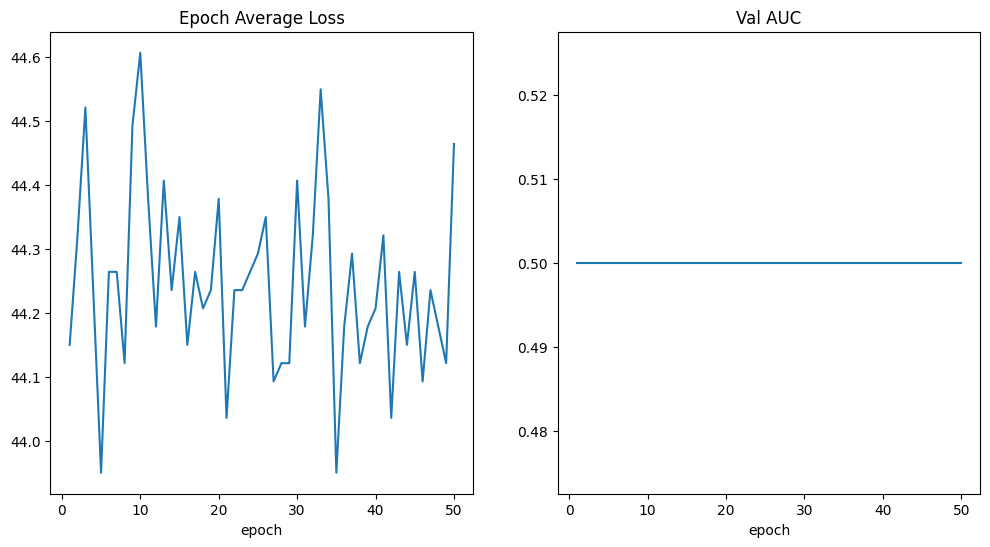

In [41]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

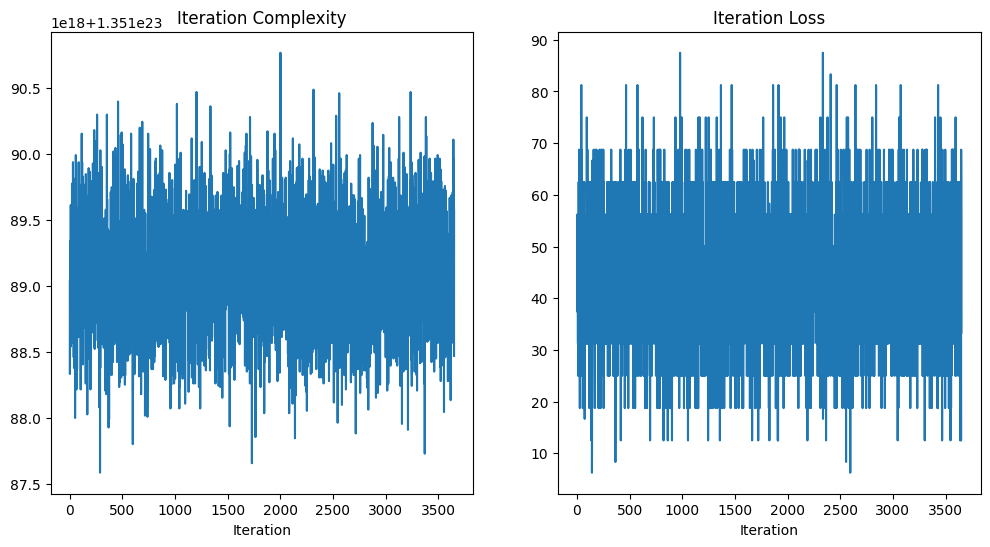

In [42]:
fig = plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Complexity")
x = [i + 1 for i in range(len(single_complexity))]
y = single_complexity
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Iteration Loss")
x = [val_interval * (i + 1) for i in range(len(single_loss))]
y = single_loss
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()
fig.savefig('complexity.png')


In [43]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
